In [1]:

from qrisp import *
from qrisp.qaoa import *

class OHQInt(QuantumVariable):

    def decoder(self, i):

        is_power_of_two = ((i & (i-1) == 0) and i != 0)

        if is_power_of_two:
            return int(np.log2(i))

        else:
            return -3

    def __eq__(self, other):

        if isinstance(other, int):

            self.encoder(other)

            eq_qbl = QuantumBool()

            cx(self[other], eq_qbl)
            return eq_qbl

        else:
            raise Exception(
                f"Comparison with type {type(other)} not implemented")

    __hash__ = QuantumVariable.__hash__

    def is_even(self):
        is_even = QuantumBool()

        for i in range(self.size):
            if not i % 2:
                cx(self[i], is_even)


        return is_even

    def is_odd(self):
        is_odd = QuantumBool()

        for i in range(self.size):
            if i % 2:
                cx(self[i], is_odd)

        return is_odd
    
    def __lt__(self, other):
        
        if isinstance(other, int):
            less_than = QuantumBool()
            for i in range(self.size):
                if i < other:
                    cx(self[i], less_than)
            return less_than
        
        else:
            raise Exception(f"Comparison for type {type(other)} not implemented")


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def W(qv,n):
    """
    This algorithms prepares tensor product of a (paraqmetrized) W-state of the first n>=1 qubits of the QuantumVariable qv and the |0> state for the remaining qubits.
    We call such a state a partial W-state of size n.

    Parameters
    ----------
    qv : QuantumVariable
        A QuantumVariable of N qubits.
    n : int
        The index n.

    """
    x(qv[0])
    for i in range(1,n):
        phi = 2*np.arcsin(1/np.sqrt(n+1-i)) # Phi for uniform superposition
        xxyy(phi,np.pi/2,qv[0],qv[i]) 


def transform(qv1, qv2, n):
    """
    This algorithm prepares a state of two QuantumVariables qv1, qv2 that is a superposition of all tensor products of basis states of length N with exactly one "1" in the first n qubits, such that 
    the QuantemVariables qv1, qv2 are never in the same state. 
    For example: qv1: |10>+|01>, qv2: |10> --->>> |10>|01> + |01>|10>. Here, the states |01>|01> and |10>|10> are forbidden.

    Parameters
    ----------
    qv1 : QuantumVariable
        N-qubit state that is a tensor product of a (parametrized) W-state of qubits q[0]...q[n] and the |0> state of qubits q[n+1]...q[N-1]
    qv2 : QuantumVariable
        N-qubit state that is a tensor product of a (parametrized) W-state of qubits q[0]...q[n-1] and |0> state of qubits q[n]...q[N-1]
    n : int
        The index n.

    """
    for i in range(n):
        with control(qv1[i]):
            xxyy(np.pi,np.pi/2,qv2[i],qv2[n]) # Swap the "1"


def state(graph, root, N):
    """
    This algorithm prepares a superposition state of all feasible solutions for a product breakdown structure (PBS) problem.
    We call this state the PBS superposition state. For this, it utilizes the PBS tree structure: A node (part) and all its (direct) predecessors can never be in the same state (site).

    Parameters
    ----------
    graph : networkx.DiGraph
        The directed graph representing the PBS.
    root : int
        The root of the graph.
    N : int
        The number sites.

    """
    M = graph.number_of_nodes()
    qtype = OHQInt(N)
    q_array = QuantumArray(qtype = qtype, shape = (1,M))

    W(q_array[0][root-1],N)
    add_predecessors(graph, root, N ,q_array)

    return q_array


def add_predecessors(graph, node, N, q_array):
    """
    A recursive algorithm to add predecessors of a node to the PBS superposition state

    Parameters
    ----------
    graph : networkx.DiGraph
        The directed graph representing the PBS.
    node : int
        The current node.
    N : int
        The number sites.
    q_array : QuantumArray
        The QuantumArray representing the PBS superposition state.

    """
    predecessors = list(PBS_graph.predecessors(node))
    #print(predecessors)
    m = len(predecessors)
    if(N<m+1):
        raise Exception(
                "Insufficient number of sites N"
        )

    # Prepare states for predecessors (partial W-states of decreasing size n)
    for i in range(m):
        W(q_array[0][predecessors[i]-1],N-1-i)

    # Create entangled state of predecessors that does satisfy constraints
    for i in range(m-2,-1,-1):
        for j in range(i+1,m):
            #print("i: " + str(i) + " j: "+str(j) + " index: " + str(N-2-i))
            transform(q_array[0][predecessors[i]-1],q_array[0][predecessors[j]-1],N-2-i)
    
    # Create entangled state of predecessors and node that does satisfy constraints
    for j in range(m):
        transform(q_array[0][node-1],q_array[0][predecessors[j]-1],N-1)

    # Recursivley add predecessors
    for pred in predecessors:
        add_predecessors(graph, pred, N ,q_array)


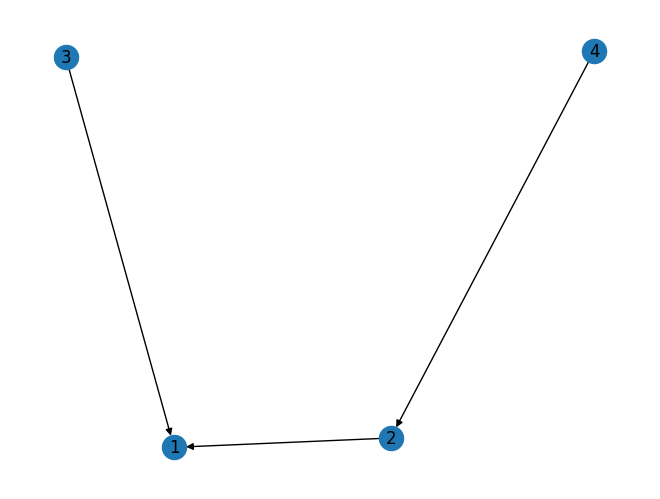

In [23]:
# Define PBS by Phi:
#Phi=[(2,1),(3,1),(4,1),(5,2),(6,2),(7,2),(8,3),(9,4),(10,4)]
#Phi = [(2,1),(3,1),(4,1),(5,2)]
#Phi = [(2,1),(3,1)]
Phi = [(2,1),(3,1),(4,2)]
root = 1

PBS_graph = nx.DiGraph()
PBS_graph.add_edges_from(Phi)
M = PBS_graph.number_of_nodes() # Number of parts

nx.draw(PBS_graph, with_labels=True)

In [26]:
test = state(PBS_graph, 1, 3)
test.qs.statevector(decimals=5)

0.28867*|0>*|1>*|2>*|0> + 0.28867*|0>*|1>*|2>**2 + 0.28867*|0>*|2>*|1>*|0> + 0.28867*|0>*|2>*|1>**2 + 0.28867*|1>*|0>*|2>*|1> + 0.28867*|1>*|0>*|2>**2 + 0.28867*|1>*|2>*|0>*|1> + 0.28867*|1>*|2>*|0>**2 + 0.28867*|2>*|0>*|1>*|2> + 0.28867*|2>*|0>*|1>**2 + 0.28867*|2>*|1>*|0>*|2> + 0.28867*|2>*|1>*|0>**2

In [27]:
####################
# TESTING
####################

# Generate Psi from PBS graph: direct subparts of a part cannot be manufactured at the same site
Psi=[]
for node in PBS_graph:
    predecessors = list(PBS_graph.predecessors(node))
    m = len(predecessors)
    for i in range(m-1):
        for j in range(i+1,m):
            Psi.append((predecessors[i],predecessors[j]))

# Get measurement results
meas_res=test.get_measurement()

# Compute the overlap of the prepared state the the not allowd subspace (result should be 0)
not_allowed = 0
for res,prob in meas_res.items():
    curr = res[0]
    # Check all constraints for Phi and Psi
    for phi in Phi+Psi:
        if(curr[phi[0]-1]==curr[phi[1]-1]):
            not_allowed+=prob
            break

not_allowed

Simulating 12 qubits.. |                                                     | [  0%]

0